In [1]:
# !export LD_LIBRARY_PATH=/openfhe-python/openfhe/:$LD_LIBRARY_PATH
# !export PYTHONPATH=/openfhe-python/openfhe/:$PYTHONPATH

# Imports

In [2]:
import sys
sys.path.append('/openfhe-python/openfhe/')
from openfhe import *
import torch
import pandas as pd
import random
from tqdm import tqdm
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

# Setup openFHE context, generate keys, encrypt and decrypt functions then test them against a test dataset

In [3]:

# Step 1: Setup OpenFHE CKKS context and generate keys
def setup_openfhe():
    params = CCParamsCKKSRNS()
    params.SetScalingModSize(40)  # Set the scaling factor for CKKS
    params.SetMultiplicativeDepth(9)  # Set the multiplicative depth
    params.SetSecurityLevel(HEStd_NotSet)
    params.SetRingDim(32768)
    params.SetScalingTechnique(FIXEDAUTO)
    params.SetBatchSize(16)
    
    cc = GenCryptoContext(params)  # Generate the CKKS context
    cc.Enable(PKESchemeFeature.PKE)  # Enable public key encryption features
    cc.Enable(PKESchemeFeature.KEYSWITCH)  # Enable key switching
    cc.Enable(PKESchemeFeature.LEVELEDSHE)  # Enable leveled homomorphic encryption
    cc.Enable(PKESchemeFeature.ADVANCEDSHE)  # Enable leveled homomorphic encryption
    cc.Enable (PKESchemeFeature.MULTIPARTY)
    print("Mod size: ",params.GetFirstModSize())
    print("Ring Dim: ",params.GetRingDim())
    return cc

# Step 2: Encrypt input using CKKS
def encrypt_input(cc, public_key, input_data):
    # Create a CKKS packed plaintext from the input data
    #print("Encrypting...")
    plaintext = cc.MakeCKKSPackedPlaintext(input_data)
    
    # Encrypt the plaintext using the public key
    ciphertext = cc.Encrypt(public_key, plaintext)
    #print("ciphertext:"+ str(ciphertext))
    return ciphertext

# Step 3: Decrypt ciphertext back to plaintext (with trimming and handling small imaginary parts)
def decrypt_input(cc, kp1_secret_key, kp2_secret_key, ciphertext, original_size):
    ciphertextPartial1 = cc.MultipartyDecryptLead([ciphertext], kp1_secret_key)
    ciphertextPartial2 = cc.MultipartyDecryptMain([ciphertext], kp2_secret_key)
    partialCiphertextVec = [ciphertextPartial1[0], ciphertextPartial2[0]]
    decrypted_plaintext = cc.MultipartyDecryptFusion(partialCiphertextVec)
    decrypted_values = decrypted_plaintext.GetCKKSPackedValue()
    trimmed_decrypted_values = decrypted_values[:original_size]
    real_decrypted_values = [np.real_if_close(value, tol=1e-15) for value in trimmed_decrypted_values]
    float_decrypted_values = [float(np.real(value)) for value in real_decrypted_values]
    return float_decrypted_values

#key generation
cc=setup_openfhe()

# For Party A
kp1 = cc.KeyGen()
evalMultKey = cc.KeySwitchGen(kp1.secretKey, kp1.secretKey)
cc.EvalSumKeyGen(kp1.secretKey)
evalSumKeys = cc.GetEvalSumKeyMap(kp1.secretKey.GetKeyTag())
cc.EvalAtIndexKeyGen(kp1.secretKey, [-1])
evalAtIndexKeys=cc.GetEvalAutomorphismKeyMap(kp1.secretKey.GetKeyTag())

# For Party B
kp2 = cc.MultipartyKeyGen(kp1.publicKey)
evalMultKey2 = cc.MultiKeySwitchGen(kp2.secretKey, kp2.secretKey, evalMultKey)

# Combine evaluation multiplication keys from both parties
evalMultAB = cc.MultiAddEvalKeys(evalMultKey, evalMultKey2, kp2.publicKey.GetKeyTag())
evalMultBAB = cc.MultiMultEvalKey(kp2.secretKey, evalMultAB, kp2.publicKey.GetKeyTag())

# Summation keys for both parties
evalSumKeysB = cc.MultiEvalSumKeyGen(kp2.secretKey, evalSumKeys, kp2.publicKey.GetKeyTag())
evalSumKeysJoin = cc.MultiAddEvalSumKeys(evalSumKeys, evalSumKeysB, kp2.publicKey.GetKeyTag())
cc.InsertEvalSumKey(evalSumKeysJoin)

# Final evaluation multiplication keys from both parties
evalMultAAB = cc.MultiMultEvalKey(kp1.secretKey, evalMultAB, kp2.publicKey.GetKeyTag())
evalMultFinal = cc.MultiAddEvalMultKeys(evalMultAAB, evalMultBAB, evalMultAB.GetKeyTag())

# Insert the final multiplication key
cc.InsertEvalMultKey([evalMultFinal])
evalAtIndexKeysB=cc.MultiEvalAtIndexKeyGen(kp2.secretKey, evalAtIndexKeys, [-1], kp2.publicKey.GetKeyTag())
evalAtIndexKeysJoin = cc.MultiAddEvalAutomorphismKeys(evalAtIndexKeys, evalAtIndexKeysB, kp2.publicKey.GetKeyTag())
cc.InsertEvalSumKey(evalAtIndexKeysJoin)#its the same function?

# Define two-party bootstrapping function
def two_party_bootstrapping(ciphertext, partyA, partyB, cc):
    # Prepare ciphertext for bootstrapping by stripping c0
    #print("Depth:", ciphertext.GetLevel())
    if ciphertext.GetLevel() < 2:
        return ciphertext
    c1 = ciphertext.Clone()
    c1.RemoveElement(0)
    
    # Generate a common random polynomial (a)
    a = cc.IntMPBootRandomElementGen(partyB.publicKey)
    
    # Each party generates its own decryption share
    share1 = cc.IntMPBootDecrypt(partyA.secretKey, c1, a)
    share2 = cc.IntMPBootDecrypt(partyB.secretKey, c1, a)
    
    # Aggregate the decryption shares
    aggregatedShares = cc.IntMPBootAdd([share1, share2])
    
    # Re-encrypt (bootstrap) the ciphertext
    bootstrapped_ciphertext = cc.IntMPBootEncrypt(partyB.publicKey, aggregatedShares, a, ciphertext)
    
    return bootstrapped_ciphertext

Mod size:  60
Ring Dim:  32768
0
0
Decrypted result: [-1.000000003394988, -1.4176545950266232e-08, 2.615055698346685e-09, 3.9999999985229744]


# Define dataset and train/test split 

In [4]:
# Set the manual seed for reproducibility
torch.random.manual_seed(73)
random.seed(73)

def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    # Use indexing on tensors to split the data
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]


def heart_disease_data():
    data = pd.read_csv("./framingham.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    #data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = torch.tensor(data["TenYearCHD"].values).float().unsqueeze(1)
    data = data.drop("TenYearCHD", axis=1)
    # standardize data
    data = (data - data.mean()) / data.std()
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)


def random_data(m=1024, n=2):
    # data separable by the line `y = x`
    x_train = torch.randn(m, n)
    x_test = torch.randn(m // 2, n)
    y_train = (x_train[:, 0] >= x_train[:, 1]).float().unsqueeze(0).t()
    y_test = (x_test[:, 0] >= x_test[:, 1]).float().unsqueeze(0).t()
    return x_train, y_train, x_test, y_test


# You can use whatever data you want without modification to the tutorial
# x_train, y_train, x_test, y_test = random_data()
x_train, y_train, x_test, y_test = heart_disease_data()

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")


############# Data summary #############
x_train has shape: torch.Size([780, 15])
y_train has shape: torch.Size([780, 1])
x_test has shape: torch.Size([334, 15])
y_test has shape: torch.Size([334, 1])
#######################################


/tmp/ipykernel_351/3717856068.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))


# Define normal linear regression model

In [5]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        #print(f"Initialized bias: {self.lr.bias.data}")
    def forward(self, x):
        #print(f"Current bias: {self.lr.bias.data}")
        out= self.lr(x)
        #print("Normal model before sigmoid: "+ str(out))
        out = torch.sigmoid(out)
        return out
        
n_features = x_train.shape[1]
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()
summary(model, input_size=(1, n_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 1]              16
Total params: 16
Trainable params: 16
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Train normal linear regression model

Total time taken for training: 0.02 seconds


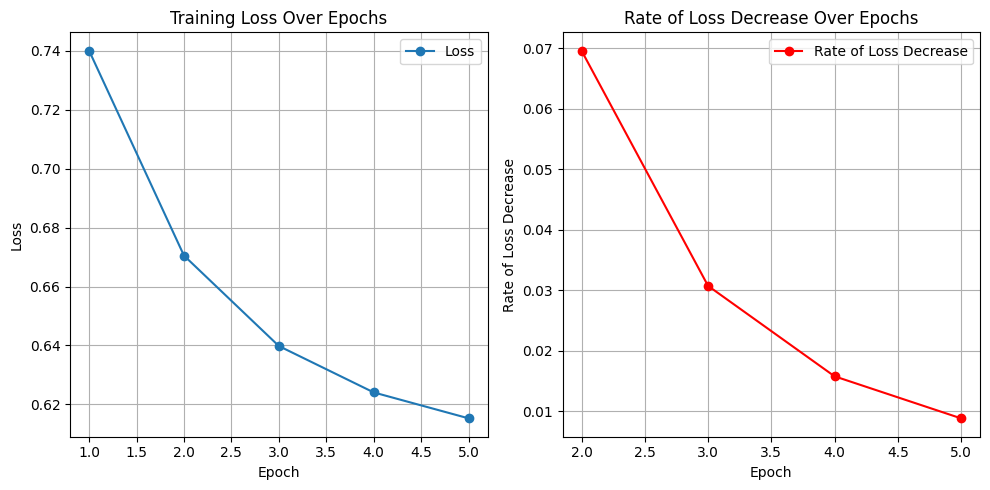

In [6]:
import time
import matplotlib.pyplot as plt

EPOCHS = 5

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    start_time = time.time()  # Record start time
    loss_history = []  # Store loss values
    loss_rate = []  # Store rate of loss decrease

    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()

        loss_value = loss.item()
        loss_history.append(loss_value)  # Store loss
        
        # Calculate rate of loss decrease (except for first epoch)
        if e > 1:
            rate = loss_history[-2] - loss_value
            loss_rate.append(rate)

        #print(f"Loss at epoch {e}: {loss_value}")

    end_time = time.time()  # Record end time
    total_time = end_time - start_time
    print(f"Total time taken for training: {total_time:.2f} seconds")

    # Plot the loss over epochs
    plt.figure(figsize=(10, 5))

    # Loss over epochs
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-', label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.legend()

    # Rate of loss decrease
    plt.subplot(1, 2, 2)
    plt.plot(range(2, epochs + 1), loss_rate, marker='o', linestyle='-', color='r', label="Rate of Loss Decrease")
    plt.xlabel("Epoch")
    plt.ylabel("Rate of Loss Decrease")
    plt.title("Rate of Loss Decrease Over Epochs")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Run training and visualize loss trends
LR_Model = train(model, optim, criterion, x_train, y_train)


# Get accuracy of normal linear regression model

Total time taken for testing: 0.00 seconds
Accuracy on plain test_set: 0.6946


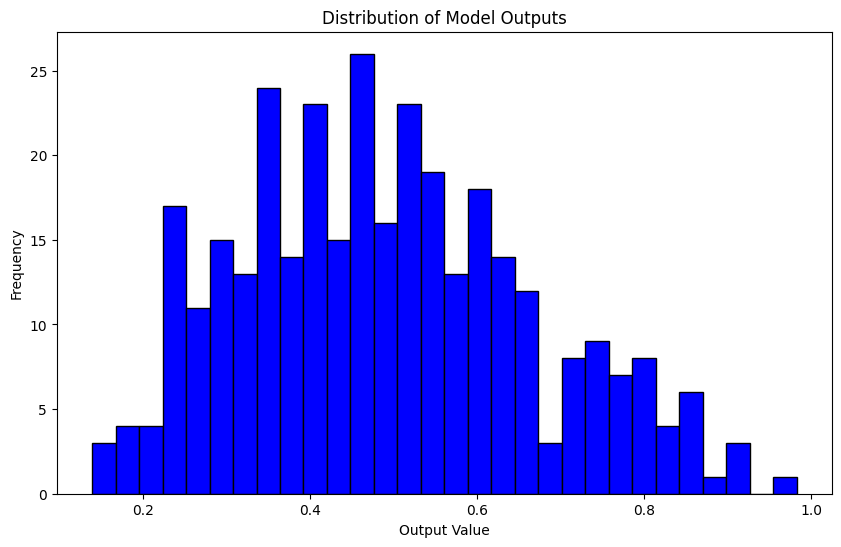

In [7]:
import matplotlib.pyplot as plt
import torch

import time
import torch
import matplotlib.pyplot as plt

def accuracy(model, x, y):
    start_time = time.time()
    
    # Compute the model output
    out = model(x)  # Ensure to use the input model parameter here
    
    # Apply threshold for binary classification
    predictions = (out >= 0.5).float()  # Convert to 1 if out >= 0.5, else 0
    
    # Calculate accuracy
    correct = (predictions == y).float()
    accuracy = correct.mean()
    
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total time taken for testing: {total_time:.2f} seconds")
    print(f"Accuracy on plain test_set: {accuracy:.4f}")
    
    # Plot the distribution of the outputs
    out_values = out.detach().numpy()  # Convert to numpy for plotting
    plt.figure(figsize=(10, 6))
    plt.hist(out_values, bins=30, color='blue', edgecolor='black')
    plt.xlabel("Output Value")
    plt.ylabel("Frequency")
    plt.title("Distribution of Model Outputs")
    plt.show()
    
    return accuracy


# Call the function with model, test inputs, and test labels
plain_accuracy = accuracy(LR_Model, x_test, y_test)


# plain_accuracy = accuracy(model, x_train, y_train)
# print(f"Accuracy on plain train_set: {plain_accuracy}")

# Define post training encrypted linear regression model

In [8]:
class EncryptedLR1:
    def __init__(self, torch_lr, cc, public_key):
        start_time = time.time()
        # Extract weights and biases from the PyTorch model
        self.weight = torch_lr.lr.weight.data.tolist()[0]  # Extract the weights from the Linear layer
        self.bias = torch_lr.lr.bias.data.tolist()  # Extract the biases from the Linear layer
        
        # Encrypt the weights and biases (done once during initialization)
        self.weight_enc = cc.Encrypt(public_key, cc.MakeCKKSPackedPlaintext(self.weight))
        self.bias_enc = cc.Encrypt(public_key, cc.MakeCKKSPackedPlaintext(self.bias))
        self.cc = cc
        end_time = time.time()
        total_time = end_time - start_time
        print(f"Total time taken for encrypting parameters: {total_time:.2f} seconds")

    def forward(self, enc_x):
        # Homomorphically multiply encrypted inputs with encrypted weights using the CryptoContext
        enc_out = self.cc.EvalInnerProduct(enc_x , self.weight_enc,15)
        enc_out = self.cc.EvalAdd(enc_out, self.bias_enc)  # Add the encrypted bias

        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

eelr1 = EncryptedLR1(LR_Model,cc,kp2.publicKey)



Total time taken for encrypting parameters: 0.09 seconds


# Encrypt test input

In [9]:
# Start the timer
t_start = time.time()

# Encrypt the test set
enc_x_test = [encrypt_input(cc, kp2.publicKey, x.tolist()) for x in x_test]

# End the timer
t_end = time.time()

# Print the time taken with more precision
print(f"Encryption of the test set took {t_end - t_start:.2f} seconds")

Encryption of the test set took 12.05 seconds


# Get accuracy of post training encrypted model

In [10]:
import matplotlib.pyplot as plt
import torch

def encrypted_evaluation1(model, enc_x_test, y_test):
    t_start = time.time()
    
    correct = 0
    outputs = []  # List to store the outputs for plotting
    
    for enc_x, y in zip(enc_x_test, y_test):
        # Encrypted evaluation
        enc_out = model(enc_x)
        
        # Decrypt the encrypted output
        out = decrypt_input(cc, kp1.secretKey, kp2.secretKey, enc_out, 1)
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        
        # Apply threshold to make binary prediction
        predicted_label = 1 if out >= 0.5 else 0
        
        # Store the output for plotting (before thresholding)
        outputs.append(out.item())
        
        # Check if the binary prediction matches the true label
        if predicted_label == y.item():  # Ensure both are scalars
            correct += 1
    
    t_end = time.time()
    total_time = t_end - t_start
    print(f"Evaluated test set of {len(enc_x_test)} entries in {total_time:.2f} seconds")
    print(f"Accuracy: {correct}/{len(enc_x_test)} = {correct / len(enc_x_test)}")
    
    # Plot the distribution of model outputs before thresholding
    plt.figure(figsize=(10, 6))
    plt.hist(outputs, bins=30, color='blue', edgecolor='black')
    plt.xlabel("Output Value")
    plt.ylabel("Frequency")
    plt.title("Distribution of Model Outputs (Before Thresholding)")
    plt.show()
    
    return correct / len(enc_x_test)

# Perform encrypted evaluation and calculate difference with plain accuracy
encrypted_accuracy = encrypted_evaluation1(eelr1, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")

KeyboardInterrupt: 

# Check the difference in output between normal model and FHE model

In [ ]:
index = 2 # For example, take the 6th input (indexing starts at 0)
single_input = x_test[index]
single_label = y_test[index]

# Encrypt
enc_single_input = enc_x_test[index]
enc_single_input_decrypted = decrypt_input(cc, kp1.secretKey, kp2.secretKey, enc_single_input, 15)
enc_single_label = y_test[index]

# Pass to model
output = LR_Model(single_input)
enc_output = eelr1(enc_single_input)
enc_output = decrypt_input(cc, kp1.secretKey, kp2.secretKey, enc_output, 1)
enc_output = torch.sigmoid(torch.tensor(enc_output ))
# Print
print(f"Input at index {index}: {single_input}")
print(f"True Label at index {index}: {single_label}")
print(f"Model Output: {output}")

print("===Encrypted===")
print(f"Input at index {index}: {enc_single_input_decrypted}")
print(f"True Label at index {index}: {enc_single_label}")
print(f"Model Output: {enc_output }")


# Training on encrypted data

In [ ]:
class EncryptedLR2:
    
    def __init__(self,cc,public_key,torch_lr):
        self.cc = cc 
        self.weight = cc.MakeCKKSPackedPlaintext(torch_lr.lr.weight.data.tolist()[0])
        self.bias = cc.MakeCKKSPackedPlaintext(torch_lr.lr.bias.data.tolist())
        print(self.weight)
        print(self.bias)
        self.weight_enc = cc.Encrypt(public_key, self.weight)
        self.bias_enc = cc.Encrypt(public_key, self.bias)
        self.zero1 = cc.Encrypt(public_key, cc.MakeCKKSPackedPlaintext([0]))  # Encrypted gradient accumulator
        self.zero9 = cc.Encrypt(public_key, cc.MakeCKKSPackedPlaintext([0]*15))  # Encrypted gradient accumulator
        self._delta_w = self.zero9 # Encrypted gradient accumulator
        self._delta_b = self.zero1  # Encrypted bias accumulator
        self._count = 0
        self.key=public_key
        
    def forward(self, enc_x):
        # Compute encrypted inner product between inputs and weights
        self.cc.RescaleInPlace(self.weight_enc)
        enc_out = self.cc.EvalInnerProduct(enc_x, self.weight_enc, 15)
        self.cc.RescaleInPlace(enc_out)
        # Perform two-party bootstrapping to refresh ciphertext
        enc_out = two_party_bootstrapping(enc_out, kp1, kp2, cc)
        enc_out = self.cc.EvalAdd(enc_out, self.bias_enc)
        # Apply the sigmoid approximation for activation
        enc_out = self.sigmoid(enc_out)

        return enc_out
    
    def backward(self,enc_x, enc_out, enc_y):
        ext_out_minus_y = cc.Encrypt(self.key,self.cc.MakeCKKSPackedPlaintext([0] * 15))
        mask=self.cc.MakeCKKSPackedPlaintext([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        out_minus_y_w= self.cc.EvalSub(enc_out,enc_y)
        out_minus_y_w= self.cc.EvalMult(out_minus_y_w,mask)
        out_minus_y_b= out_minus_y_w
        
        for i in range(15):
            ext_out_minus_y = cc.EvalAdd(out_minus_y_w, ext_out_minus_y)
            # Slide out_minus_y_w to the next position
            out_minus_y_w = cc.EvalAtIndex(out_minus_y_w, -1)

        intermediate_val=self.cc.EvalMult(enc_x,ext_out_minus_y)
        intermediate_val = two_party_bootstrapping(intermediate_val, kp1, kp2, self.cc)
        self.cc.RescaleInPlace(intermediate_val)
        self._delta_w = self.cc.EvalAdd(self._delta_w,intermediate_val)
        self._delta_b= self.cc.EvalAdd(self._delta_b,out_minus_y_b)
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        
        # Step 1: Multiply `self.weight_enc` by 0.05
        term1 = self.cc.EvalMult(self.weight_enc, self.cc.MakeCKKSPackedPlaintext([0.05] * 15))
        self.cc.RescaleInPlace(term1)
        # Step 2: Multiply `_delta_w` by (1 / _count)
        term2 = self.cc.EvalMult(self._delta_w, self.cc.MakeCKKSPackedPlaintext([1 / self._count] * 15))
        self.cc.RescaleInPlace(term2)
        # Step 3: Add term1 and term2, then bootstrap to manage noise
        intermediate_sum = self.cc.EvalAdd(term1, term2)
        
        # Step 4: Update `self.weight_enc`
        self.weight_enc = self.cc.EvalSub(self.weight_enc, intermediate_sum)
        self.weight_enc = two_party_bootstrapping(self.weight_enc, kp1, kp2, cc) 
    
        # Update bias with correct scaling
        delta_b_scaled = self.cc.EvalMult(self._delta_b, self.cc.MakeCKKSPackedPlaintext([1 / self._count]))
        delta_b_scaled = two_party_bootstrapping(delta_b_scaled, kp1, kp2, cc)
        self.bias_enc = self.cc.EvalSub(self.bias_enc, delta_b_scaled)

        # Reset gradient accumulators and count
        self._delta_w = self.zero9
        self._delta_b = self.zero1
        self._count = 0
    
        # Print final decrypted weights and biases
        print("Updated Weights:", decrypt_input(cc, kp1.secretKey, kp2.secretKey, self.weight_enc, 15))
        print("Updated Bias:", decrypt_input(cc, kp1.secretKey, kp2.secretKey, self.bias_enc, 1))

    
    def sigmoid(self, enc_x):
        # Polynomial coefficients: [0.5, 0.197, 0, -0.004]
        coeff_0 = self.cc.MakeCKKSPackedPlaintext([0.5])  # Constant term
        coeff_1 = self.cc.MakeCKKSPackedPlaintext([0.197])  # Linear term
        coeff_3 = self.cc.MakeCKKSPackedPlaintext([-0.004])  # Cubic term
    
        # Evaluate cubic term: -0.004 * x^3
        enc_x_squared = self.cc.EvalMult(enc_x, enc_x)  # x^2
        self.cc.RescaleInPlace(enc_x_squared)
        enc_x_cubed = self.cc.EvalMult(enc_x_squared, enc_x)  # x^3
        self.cc.RescaleInPlace(enc_x_squared)
        term_cubic = self.cc.EvalMult(enc_x_cubed, coeff_3)  # -0.004 * x^3
        self.cc.RescaleInPlace(enc_x_squared)
        # Evaluate linear term: 0.197 * x
        term_linear = self.cc.EvalMult(enc_x, coeff_1)  # 0.197 * x
        self.cc.RescaleInPlace(term_linear)
        #term_linear = two_party_bootstrapping(term_linear, kp1, kp2, cc)
        # Sum all terms: 0.5 + 0.197 * x - 0.004 * x^3
        enc_out = self.cc.EvalAdd(term_cubic, term_linear)
    
        enc_out = self.cc.EvalAdd(enc_out, coeff_0)  # Final sigmoid approximation
        self.cc.RescaleInPlace(enc_out)
        #print("Sigmoid:", decrypt_input(cc, kp1.secretKey, kp2.secretKey, enc_out, 1))
    
        return enc_out

    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [ ]:
t_start = time.time()

# Encrypt and bootstrap X train
enc_x_train_initial = [
    encrypt_input(cc, kp2.publicKey, x.tolist())
    for x in tqdm(x_train, desc="Encrypting and Bootstrapping X train")
]

# Encrypt and bootstrap Y train
enc_y_train_initial = [
    encrypt_input(cc, kp2.publicKey, y.tolist())
    for y in tqdm(y_train, desc="Encrypting and Bootstrapping Y train")
]

t_end = time.time()
total_time = t_end - t_start
print(f"Encryption and bootstrapping of the train-set took {total_time:.2f} seconds")


In [ ]:
# Initialize the model
eelr2 = EncryptedLR2(cc, kp2.publicKey, LR(n_features))

# List to track time per epoch
times = []
t_start = time.time()

# Loop through the epochs with a progress bar
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    enc_x_train = enc_x_train_initial
    enc_y_train = enc_y_train_initial
    
    # Use tqdm to add a loading bar to the inner loop
    for i, (enc_x, enc_y) in enumerate(tqdm(zip(enc_x_train, enc_y_train), total=len(enc_x_train), desc=f"Training epoch {epoch+1}")):
        
        # Perform forward and backward pass
        enc_out = eelr2.forward(enc_x)
        eelr2.backward(enc_x, enc_out, enc_y)

    # Update model parameters after processing the entire dataset
    eelr2.update_parameters()
t_end = time.time()
total_time = t_end - t_start
print(f"\nTraining of train-set took {total_time:.2f} seconds")


In [ ]:
def encrypted_evaluation2(model, enc_x_test, y_test):
    t_start = time.time()
    
    correct = 0
    outputs = []  # List to store the outputs for plotting
    
    for enc_x, y in zip(enc_x_test, y_test):
        # Encrypted evaluation
        enc_out = model(enc_x)
        
        # Decrypt the encrypted output
        out = decrypt_input(cc, kp1.secretKey, kp2.secretKey, enc_out, 1)
        out = torch.tensor(out)
        
        # Apply threshold to make binary prediction
        predicted_label = 1 if out >= 0.5 else 0
        
        # Store the output for plotting (before thresholding)
        outputs.append(out.item())
        
        # Check if the binary prediction matches the true label
        if predicted_label == y.item():  # Ensure both are scalars
            correct += 1
    
    t_end = time.time()
    total_time = t_end - t_start
    print(f"Evaluated test set of {len(enc_x_test)} entries in {total_time:.2f} seconds")
    print(f"Accuracy: {correct}/{len(enc_x_test)} = {correct / len(enc_x_test)}")
    
    # Plot the distribution of model outputs before thresholding
    plt.figure(figsize=(10, 6))
    plt.hist(outputs, bins=30, color='blue', edgecolor='black')
    plt.xlabel("Output Value")
    plt.ylabel("Frequency")
    plt.title("Distribution of Model Outputs (Before Thresholding)")
    plt.show()
    
    return correct / len(enc_x_test)

encrypted_accuracy = encrypted_evaluation2(eelr2, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")